In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo

In [60]:
df = pd.read_json('data/elonDFCleanV7.json')

In [61]:
df.tail()

,retweet_count,fav_count,tweetLen,Business positive,Business neutral,Business negative,Personal positive,Personal neutral,Personal negative,compound,High,Low,Open,Close,Volume,Adj Close,dayOfWeek
2020-07-27,154954,1337692,145,4,0,0,9,10,2,0.9896,1547.939941,1413.000000,1435.0,1539.599976,16048700.0,1476.489990,1
2020-07-28,1245,28715,73,0,0,0,3,2,2,-0.1134,1564.699951,1474.420044,1504.0,1476.489990,15808700.0,1499.109985,5
2020-07-29,5303,100007,79,1,0,0,3,5,0,0.8756,1534.810059,1487.000000,1501.0,1499.109985,9426900.0,1487.489990,6
2020-07-30,91933,1162051,309,4,0,0,10,7,3,0.9925,1513.239990,1471.000000,1488.0,1487.489990,7621000.0,1430.760010,4
2020-07-31,85083,770873,70,0,0,0,5,3,1,0.8663,1513.239990,1471.000000,1488.0,1487.489990,7621000.0,1430.760010,0


In [62]:
scaler = MinMaxScaler()
#Column Transformer to avoid Data Leakage 
ct = make_column_transformer(
    (scaler, ['retweet_count', 'fav_count', 'tweetLen', 'Business positive',
       'Business neutral', 'Business negative', 'Personal positive',
       'Personal neutral', 'Personal negative', 'Open', 'Volume']),
    remainder='passthrough')

In [63]:
#have to push day back one day
#then scale the numbers 

In [64]:
df.corr()['Adj Close']

retweet_count        0.291756
fav_count            0.430176
tweetLen             0.269845
Business positive    0.216024
Business neutral     0.184582
Business negative         NaN
Personal positive    0.382224
Personal neutral     0.361614
Personal negative    0.305272
compound             0.242754
High                 0.996270
Low                  0.996813
Open                 0.995678
Close                0.997616
Volume               0.509792
Adj Close            1.000000
dayOfWeek           -0.015877
Name: Adj Close, dtype: float64

In [65]:
#drop DayOfweek, compound and Close
df = df.drop(columns = ['dayOfWeek', 'Close', 'compound', 'Low', 'High'])

In [66]:
df.shape

(2712, 12)

In [67]:
df.corr()['Adj Close']

retweet_count        0.291756
fav_count            0.430176
tweetLen             0.269845
Business positive    0.216024
Business neutral     0.184582
Business negative         NaN
Personal positive    0.382224
Personal neutral     0.361614
Personal negative    0.305272
Open                 0.995678
Volume               0.509792
Adj Close            1.000000
Name: Adj Close, dtype: float64

In [71]:
#Do a train Test Split to avoid data leakage for our time series model 
X = df.loc[:, df.columns != 'Adj Close']
y = pd.DataFrame(df.loc[:, 'Adj Close'])

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 777)

In [73]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2440, 11), (272, 11), (2440, 1), (272, 1))

In [74]:
#X_train_scale = scaler.fit_transform(X_train)

In [75]:
#Create the models 
rf = RandomForestRegressor()
model1 = make_pipeline(ct, rf)
%time model1.fit(X_train, y_train)

CPU times: user 92.5 ms, sys: 2.64 ms, total: 95.1 ms
Wall time: 94.1 ms


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(copy=True,
                                                               feature_range=(0,
                                                                              1)),
                                                  ['retweet_count', 'fav_count',
                                                   'tweetLen',
                                                   'Business positive',
                                                   'Business neutral',
                                                   'Business negative',
                                                   'Personal positive',
              

In [76]:
#Show the model tree predictions
pred_model1 = model1.predict(X_test)

In [77]:
y_test1 = y_test.values

In [78]:
#Get rmse
rmse = np.sqrt(np.mean(pred_model1 - y_test1)** 2)
rmse

0.6205135720034204

In [79]:
#xgboost 
xgb = XGBRegressor()
model2 = make_pipeline(ct, xgb)
%time model2.fit(X_train,y_train)

CPU times: user 1.07 s, sys: 23.1 ms, total: 1.09 s
Wall time: 103 ms


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(copy=True,
                                                               feature_range=(0,
                                                                              1)),
                                                  ['retweet_count', 'fav_count',
                                                   'tweetLen',
                                                   'Business positive',
                                                   'Business neutral',
                                                   'Business negative',
                                                   'Personal positive',
              

In [80]:
#show XGB model prediction
pred_model2 = model2.predict(X_test)

In [81]:
#Get rmse
rmse = np.sqrt(np.mean(pred_model2 - y_test1)** 2)
rmse

1.0558982830434702

In [82]:
validation = y_test.reset_index()

In [83]:
validation['Prediction_rf'] = pred_model1
validation['Prediction_xgb'] = pred_model2

In [84]:
validation = validation.sort_values(by = 'index', ascending = False)

In [85]:
#visulize using plotly to see how well we did 
fig = go.Figure()
fig.add_trace(go.Scatter(x=validation['index'], y=validation['Adj Close'], name="Actual",
                         line_color='red'))

fig.add_trace(go.Scatter(x=validation['index'], y=validation['Prediction_rf'], name="Pred_rf",
                         line_color='purple'))

fig.add_trace(go.Scatter(x=validation['index'], y=validation['Prediction_xgb'], name="Pred_xgb",
                         line_color='pink'))

fig.update_layout(title_text='Tesla Model Price Prediction', width=700,
    height=600, xaxis_rangeslider_visible=True)
fig.show()

In [86]:
#HyperParameter 

In [112]:
#Set parameters for randomforest to tune 
params = {}
params['randomforestregressor__max_depth'] = np.arange(1,1000,50)
params['randomforestregressor__n_estimators'] = np.arange(10, 1000, 50)
params['randomforestregressor__min_samples_leaf'] = np.arange(1,20,1)

In [113]:
#Set up grid for hyperparameter tuning 
grid1 = RandomizedSearchCV(model1, params, cv = 5, n_jobs = -1, random_state = 777, n_iter = 20)

In [114]:
#Hyperparameter tuning for xgboost 
%time grid1.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



CPU times: user 4.43 s, sys: 57 ms, total: 4.48 s
Wall time: 46.3 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('minmaxscaler',
                                                                               MinMaxScaler(copy=True,
                                                                                            feature_range=(0,
                                                                                                           1)),
                                                              

In [115]:
#Looking at the best model results 
results = pd.DataFrame(grid1.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,7.021305,0.052563,0.139890,0.003326,610,2,551,"{'randomforestregressor__n_estimators': 610, '...",0.993234,0.991222,0.991948,0.993244,0.992962,0.992522,0.000805,1
6,4.030987,0.033463,0.081067,0.004221,360,2,351,"{'randomforestregressor__n_estimators': 360, '...",0.993184,0.991193,0.991774,0.993362,0.992908,0.992484,0.000850,2
8,7.460660,0.027871,0.148747,0.007856,760,4,451,"{'randomforestregressor__n_estimators': 760, '...",0.993317,0.991120,0.991540,0.993272,0.992526,0.992355,0.000893,3
5,4.247907,0.054714,0.096755,0.005620,460,5,751,"{'randomforestregressor__n_estimators': 460, '...",0.993277,0.990840,0.991140,0.993325,0.992418,0.992200,0.001044,4
18,4.260958,0.215731,0.071481,0.013810,460,5,301,"{'randomforestregressor__n_estimators': 460, '...",0.993227,0.990897,0.991175,0.993344,0.992339,0.992196,0.001013,5


In [116]:
#The best score using our search of xgboost
grid1.best_score_

0.9925221627105569

In [117]:
#Best parameters 
grid1.best_params_

{'randomforestregressor__n_estimators': 610,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__max_depth': 551}

In [118]:
#how well is our prediciton after tuning
grid_pred1 = grid1.predict(X_test)

In [120]:
#Get rmse
rmse = np.sqrt(np.mean(grid_pred1 - y_test1)** 2)
rmse

0.9696636093833938

In [121]:
#Set parameters for xgboost to tune 
params = {}
params['xgbregressor__n_estimators'] = np.arange(1,1000,50)
params['xgbregressor__max_depth'] = np.arange(1,1000,50)
params['xgbregressor__min_child_weight'] = np.arange(1, 20, 1)

In [122]:
#Set up grid for hyperparameter tuning 
grid2 = RandomizedSearchCV(model2, params, cv = 5, n_jobs = -1, random_state = 777, n_iter = 20)

In [123]:
#Hyperparameter tuning for xgboost 
%time grid2.fit(X_train, y_train)

CPU times: user 4.51 s, sys: 77.5 ms, total: 4.59 s
Wall time: 1min 31s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('minmaxscaler',
                                                                               MinMaxScaler(copy=True,
                                                                                            feature_range=(0,
                                                                                                           1)),
                                                              

In [124]:
#Looking at the best model results 
results = pd.DataFrame(grid2.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__n_estimators,param_xgbregressor__min_child_weight,param_xgbregressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,1.520153,0.063023,0.014599,0.000485,51,5,851,"{'xgbregressor__n_estimators': 51, 'xgbregress...",0.992690,0.990718,0.991935,0.991253,0.993779,0.992075,0.001079,1
5,8.802526,0.524517,0.069937,0.012173,451,5,751,"{'xgbregressor__n_estimators': 451, 'xgbregres...",0.992576,0.990793,0.991910,0.991333,0.993718,0.992066,0.001017,2
18,9.254757,0.373120,0.059336,0.007551,451,5,301,"{'xgbregressor__n_estimators': 451, 'xgbregres...",0.992576,0.990793,0.991910,0.991333,0.993718,0.992066,0.001017,2
1,10.821246,0.639191,0.119230,0.013405,951,6,901,"{'xgbregressor__n_estimators': 951, 'xgbregres...",0.992088,0.990144,0.990802,0.992171,0.993348,0.991711,0.001124,4
8,6.869359,0.394583,0.053781,0.003625,751,4,451,"{'xgbregressor__n_estimators': 751, 'xgbregres...",0.992550,0.990309,0.990674,0.990411,0.994163,0.991621,0.001510,5


In [125]:
#The best score using our search of xgboost
grid2.best_score_

0.9920750673971048

In [126]:
#Best parameters 
grid2.best_params_

{'xgbregressor__n_estimators': 51,
 'xgbregressor__min_child_weight': 5,
 'xgbregressor__max_depth': 851}

In [127]:
#how well is our prediciton after tuning
grid_pred2 = grid2.predict(X_test)

In [128]:
#Get rmse
rmse = np.sqrt(np.mean(grid_pred2 - y_test1)** 2)
rmse

1.1246046832976633

In [129]:
import matplotlib.pyplot as plt

In [130]:
plt.style.use('fivethirtyeight')

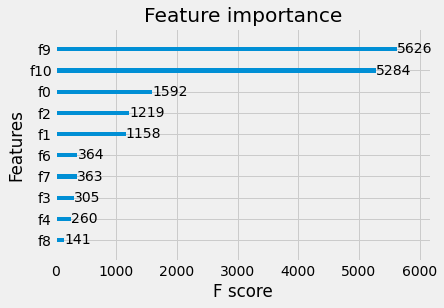

In [131]:
#lets look at our feature importance 
from xgboost import plot_importance
plot_importance(grid2.best_estimator_.named_steps['xgbregressor'], max_num_features = 10)
plt.show()

In [132]:
#Feature importance vs their name, still have to find a way to access tfidfvector
for col,score in zip(X_train.columns,grid2.best_estimator_.named_steps['xgbregressor'].feature_importances_):
    print(col,score)

retweet_count 0.0014913935
fav_count 0.0011018803
tweetLen 0.002772917
Business positive 0.0014061782
Business neutral 0.0023037135
Business negative 0.0
Personal positive 0.0037213876
Personal neutral 0.0014253978
Personal negative 0.004577721
Open 0.9800373
Volume 0.0011621305


In [133]:
validation = y_test.reset_index()
validation['Prediction_rf_grid'] = grid_pred1
validation['Prediction_xgb_grid'] = grid_pred2
validation = validation.sort_values(by = 'index', ascending = False)

In [134]:
#visulize using plotly to see how well we did 
fig = go.Figure()
fig.add_trace(go.Scatter(x=validation['index'], y=validation['Adj Close'], name="Actual",
                         line_color='blue'))

fig.add_trace(go.Scatter(x=validation['index'], y=validation['Prediction_rf_grid'], name="Pred_rf",
                         line_color='green'))

fig.add_trace(go.Scatter(x=validation['index'], y=validation['Prediction_xgb_grid'], name="Pred_xgb",
                         line_color='red'))

fig.update_layout(title_text='Tesla Model Price Prediction', width=700,
    height=600, xaxis_rangeslider_visible=True)
fig.show()

In [135]:
import joblib

In [136]:
# save the model to disk
filename = 'grid_rf_modelV7.sav'
joblib.dump(grid1, filename)
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9921265258535278


In [137]:
# save the model to disk
filename = 'grid_xgb_modelV7.sav'
joblib.dump(grid2, filename)
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.992323915043524
